## Base Line Model Using ID's as input

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pprint
from sklearn.pipeline import Pipeline
from collections import Counter
from sklearn.model_selection import cross_validate, cross_val_score, StratifiedKFold
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
import itertools
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
## Data loading from CSV files 
# Train data
ingredient_name = pd.read_csv(os.getcwd() + '/project description/node_ingredient.txt', engine='python', delimiter=',,', header=None)
df = pd.read_csv(os.getcwd() + '/project description/train.csv', engine= 'python', sep='\,',  names=list(range(60)))

# Validation data
VLabels = pd.read_csv(os.getcwd() + '/project description/validation_classification_answer.csv', engine='python', delimiter=',,', header=None)
VRecipe = pd.read_csv(os.getcwd() + '/project description/validation_classification_question.csv', engine= 'python', sep='\,',  names=list(range(59)), dtype='float32')

In [3]:
## Data conversion to list
# train data
IngredientList = (np.squeeze(ingredient_name.values)).tolist()
df1 = df.fillna(0)
df_2 = df1.values.tolist()

# validation data
ValReci = VRecipe.fillna(0)
VRecipes = ValReci.values.tolist()
VLabels = (np.squeeze(VLabels.values)).tolist()

In [4]:
# Separating the cuisines from the recipies for train data 
TrainRecipeList = []
Cuisines = []
for i, val in enumerate(df_2):
    R_l = [v for v in val if v !=0]
    TrainRecipeList.append(R_l[:-1]) 
    Cuisines.append(R_l[-1])

In [5]:
def ToRecipeString(RecipeIDs: list):
    # Removes 0s padded to the recipe in document read
    RecipeList = []
    for i, IDs in enumerate(RecipeIDs):
        R_l = [str(int(v)) for v in IDs if v !=0]
        RecipeList.append(R_l) 
    
    # combines IDs in Recipe as one string
    RecipeStrings = []
    for r in RecipeList:
        RecipeStrings.append(' '.join(r))
        
    return RecipeStrings

['greek', 'filipino', 'indian', 'jamaican', 'spanish', 'italian', 'mexican', 'vietnamese', 'thai', 'southern_us', 'chinese', 'cajun_creole', 'brazilian', 'french', 'japanese', 'irish', 'moroccan', 'korean', 'british', 'russian']
[714, 452, 1748, 280, 590, 4678, 3836, 487, 903, 2515, 1599, 920, 283, 1543, 840, 404, 496, 474, 485, 300]


Text(0, 0.5, 'Counts')

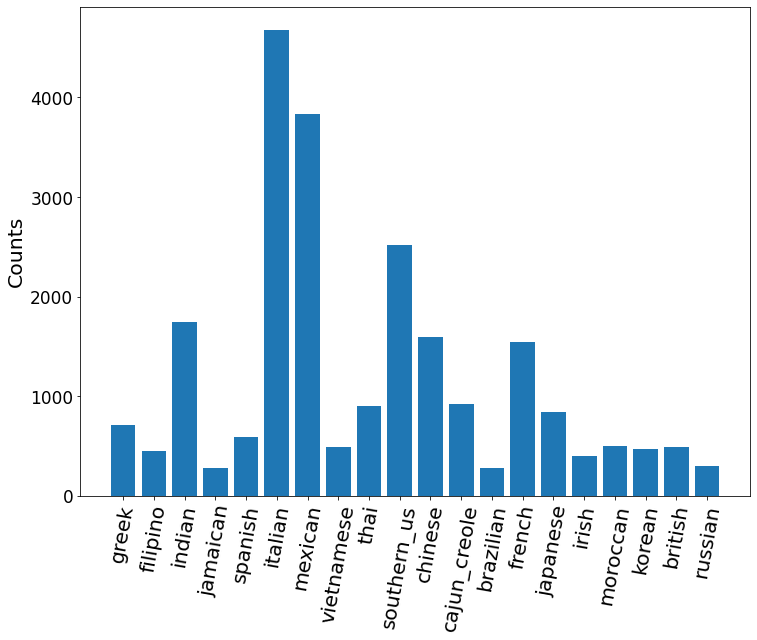

In [16]:
#plot the class counts as a bar chart
cuisine_counts = Counter(Cuisines)
print(list(cuisine_counts.keys()))
print(list(cuisine_counts.values()))

plt.figure(figsize=(12,9))
plt.bar(list(cuisine_counts.keys()), list(cuisine_counts.values()))
plt.xticks(list(cuisine_counts.keys()), list(cuisine_counts.keys()), rotation=80, fontsize='large');
plt.rcParams["font.size"] = "17"
plt.ylabel('Counts', fontsize='large')
# plt.title('Cuisine (Class) Counts')

In [31]:
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):
     
    '''
This function is modified to show the color range as normalized to f1 score
both f1 score and class count are printed in the squares
    '''
    
    if normalize:
        cm_normal = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] 
    plt.figure(figsize=(14, 14))

    im = plt.imshow(cm_normal, interpolation='nearest', cmap=cmap)
    plt.grid(None) 
    plt.colorbar(im,fraction=0.046, pad=0.04)
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=70, fontsize='large')
    plt.yticks(tick_marks, classes, fontsize='large')
    normalize = False
    
    thresh = cm_normal.max() / 2.
    for i, j in itertools.product(range(cm_normal.shape[0]), range(cm_normal.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm_normal[i, j] > thresh else "black")
        plt.text(j, i+0.25, format(cm_normal[i, j], '.2f'),
         horizontalalignment="center",
         color="white" if cm_normal[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize='large')
    plt.xlabel('Predicted label', fontsize='large')
    plt.tight_layout()

# Classification Task

## Model Preliminary Exploration on vectorizers
#1: Countvectorizer
#2: Tfidfvectorizer

In [18]:
classes=['brazilian', 'british','cajun_creole','chinese','filipino','french', 'greek', 'indian', 'irish', 'italian', 
         'jamaican', 'japanese', 'korean', 'mexican', 'moroccan', 'russian', 'southern_us', 'spanish', 'thai', 'vietnamese']

RecipeStrings = ToRecipeString(TrainRecipeList)
ValRecipeStrings = ToRecipeString(VRecipes)

In [19]:
pp = pprint.PrettyPrinter(indent=4)
skf=StratifiedKFold(n_splits=3)

## cross validation test for Logistic Regression
print("\nResults for LR tfidf vectorizer")
lr_pipe = Pipeline([('vect', TfidfVectorizer(ngram_range=(1, 1))), ('lr', LogisticRegression(max_iter=1000,random_state=123, multi_class='multinomial', solver='lbfgs'))])
cvr = cross_validate(lr_pipe, RecipeStrings, Cuisines, scoring='f1_weighted', cv = skf, return_train_score=True )
 
pp.pprint(cvr)
print('============================================================')
print('Average test and train F1 score:')
print(sum(cvr['test_score']/len(cvr['test_score'])))
print(sum(cvr['train_score']/len(cvr['train_score'])))

print("\nResults for LR count vector")
lr_pipe = Pipeline([('vect', CountVectorizer(ngram_range=(1, 1))), ('lr', LogisticRegression( max_iter=1000,random_state=123, multi_class='multinomial', solver='lbfgs'))])
cvr = cross_validate(lr_pipe, RecipeStrings, Cuisines, scoring='f1_weighted', cv = skf, return_train_score=True )

pp.pprint(cvr)
print('============================================================')
print('Average test and train F1 score:')
print(sum(cvr['test_score']/len(cvr['test_score'])))
print(sum(cvr['train_score']/len(cvr['train_score'])))

## cross validation test for Random Forest Classifier
print("\nResults for RF tfidf vectorizer")
rf_pipe= Pipeline([('vect', TfidfVectorizer(ngram_range=(1, 1))), ('lr', RandomForestClassifier(n_estimators=100, random_state=123))])
cvr = cross_validate(rf_pipe, RecipeStrings, Cuisines, scoring='f1_weighted', cv=skf, return_train_score=True )

pp.pprint(cvr)
print('============================================================')
print('Average test and train F1 score:')
print(sum(cvr['test_score']/len(cvr['test_score'])))
print(sum(cvr['train_score']/len(cvr['train_score'])))

print("\nResults for RF count vector")
rf_pipe= Pipeline([('vect', CountVectorizer(ngram_range=(1, 1))), ('lr', RandomForestClassifier(n_estimators=100, random_state=123))])
cvr = cross_validate(rf_pipe, RecipeStrings, Cuisines, scoring='f1_weighted', cv=skf, return_train_score=True )

pp.pprint(cvr)
print('============================================================')
print('Average test and train F1 score:')
print(sum(cvr['test_score']/len(cvr['test_score'])))
print(sum(cvr['train_score']/len(cvr['train_score'])))

## cross validation test for Multinomial Naive Bayesian
print("\nResults for MNB tfidf vectorizer")
mnb_pipe= Pipeline([('vect', TfidfVectorizer(ngram_range=(1, 1))), ('mnb', MultinomialNB())])
cvr = cross_validate(mnb_pipe, RecipeStrings, Cuisines, scoring='f1_weighted', cv=skf, return_train_score=True )

pp.pprint(cvr)
print('============================================================')
print('Average test and train F1 score:')
print(sum(cvr['test_score']/len(cvr['test_score'])))
print(sum(cvr['train_score']/len(cvr['train_score'])))

print("\nresults for MNB count vector")
mnb_pipe = Pipeline([('vect', CountVectorizer(ngram_range=(1, 1))), ('mnb', MultinomialNB())])
cvr = cross_validate(mnb_pipe, RecipeStrings, Cuisines, scoring='f1_weighted', cv=skf, return_train_score=True )

pp.pprint(cvr)
print('============================================================')
print('Average test and train F1 score:')
print(sum(cvr['test_score']/len(cvr['test_score'])))
print(sum(cvr['train_score']/len(cvr['train_score'])))

## cross validation test for Linear Support Vector Classifier
print("\nResults for LSVC tfidf vectorizer")
lsvc_pipe= Pipeline([('vect', TfidfVectorizer(ngram_range=(1, 1))), ('lsvc', LinearSVC(random_state=0, tol=1e-5, max_iter=1000))])
cvr = cross_validate(lsvc_pipe, RecipeStrings, Cuisines, scoring='f1_weighted', cv=skf, return_train_score=True )

pp.pprint(cvr)
print('============================================================')
print('Average test and train F1 score:')
print(sum(cvr['test_score']/len(cvr['test_score'])))
print(sum(cvr['train_score']/len(cvr['train_score'])))

print("\nresults for LSVC count vector")
lsvc_pipe = Pipeline([('vect', CountVectorizer(ngram_range=(1, 1))), ('lsvc', LinearSVC(random_state=0, tol=1e-5, max_iter=1000))])
cvr = cross_validate(lsvc_pipe, RecipeStrings, Cuisines, scoring='f1_weighted', cv=skf, return_train_score=True )

pp.pprint(cvr)
print('============================================================')
print('Average test and train F1 score:')
print(sum(cvr['test_score']/len(cvr['test_score'])))
print(sum(cvr['train_score']/len(cvr['train_score'])))


Results for LR tfidf vectorizer
{   'fit_time': array([3.28773761, 2.99497342, 3.08375144]),
    'score_time': array([0.06579494, 0.07482696, 0.06482887]),
    'test_score': array([0.73263609, 0.72229487, 0.73206162]),
    'train_score': array([0.81626131, 0.81785367, 0.81571086])}
Average test and train F1 score:
0.7289975260648913
0.8166086137483826

Results for LR count vector
{   'fit_time': array([3.48507214, 3.53950238, 3.70413637]),
    'score_time': array([0.06585312, 0.06283092, 0.06183052]),
    'test_score': array([0.74501642, 0.74288391, 0.74878886]),
    'train_score': array([0.91789473, 0.9144392 , 0.91510007])}
Average test and train F1 score:
0.7455630638950331
0.9158113334221544

Results for RF tfidf vectorizer
{   'fit_time': array([10.95768642, 11.27960014, 11.26454163]),
    'score_time': array([0.34710097, 0.39397335, 0.39394593]),
    'test_score': array([0.65048678, 0.65293078, 0.65223113]),
    'train_score': array([1., 1., 1.])}
Average test and train F1 score

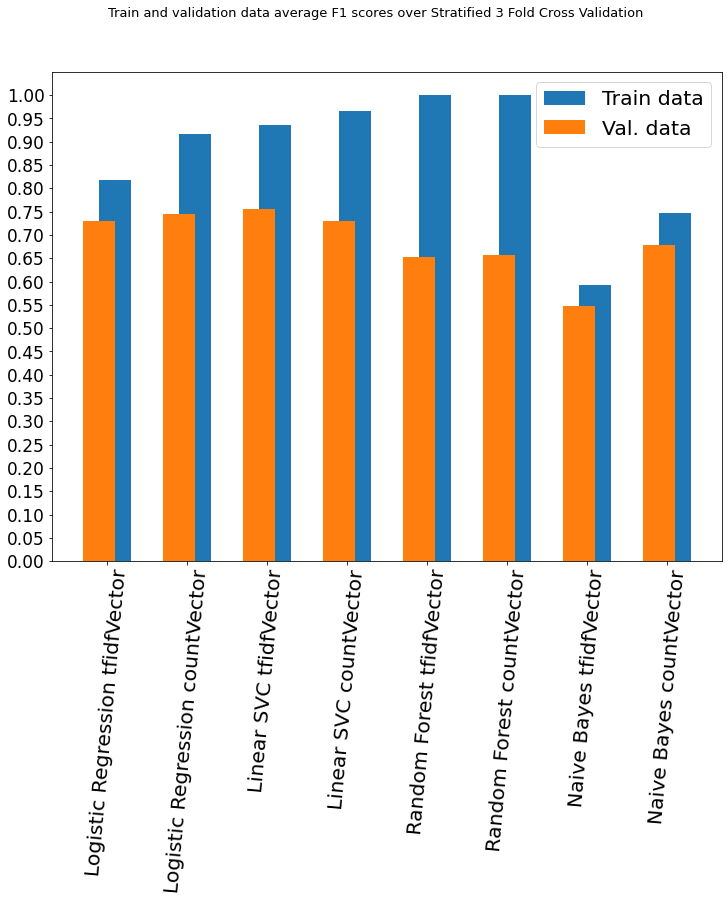

In [26]:
#sorted by test score - This could be made into a dictionary and sorted by test key value
y = ['Logistic Regression tfidfVector','Logistic Regression countVector', 'Linear SVC tfidfVector','Linear SVC countVector',
     'Random Forest tfidfVector','Random Forest countVector', 'Naive Bayes tfidfVector', 'Naive Bayes countVector']

x_train = [0.817, 0.916, 0.937, 0.966, 1.0, 1.0, 0.592, 0.748]
x_test = [0.729, 0.746, 0.756, 0.729, 0.652, 0.657, 0.547, 0.679]

ind = np.arange(len(y))
width = 0.2 
fig, axs = plt.subplots(1, 1, figsize=(12, 9), sharey=True)
fig.suptitle('Train and validation data average F1 scores over Stratified 3 Fold Cross Validation', size=13)
axs.bar(ind + width, x_train, label='Train data', width=0.4)
axs.bar(ind , x_test, label='Val. data', width=0.4)
axs.set_xticks(ind+0.1)
axs.set_xticklabels(y, rotation=85, fontsize='large')
axs.set_yticks(np.arange(0,1.01,.05))
axs.legend(loc='best', fontsize = 'large')

## Focused Training on Best Baseline Models
#1: Logistic Regression with countVectorizer
#2: Linear SVC with tfidfVectorizer

In [28]:
from sklearn.metrics import classification_report, f1_score, confusion_matrix

# Logistic Regression with CountVectorizer
vectorizer = CountVectorizer(ngram_range=(1, 1))

# tokenize and build vocab
matrix_train = vectorizer.fit_transform(RecipeStrings)
matrix_test = vectorizer.transform(ValRecipeStrings)

lr_clf = LogisticRegression(max_iter=1000,random_state=123, multi_class='auto', solver='lbfgs')
lr_clf.fit(matrix_train, Cuisines)

y_pred = lr_clf.predict(matrix_test)

print('f1 score weighted %s' % f1_score(VLabels,y_pred, average='weighted'))
print(classification_report(VLabels, y_pred))
cm_lr_test=confusion_matrix(VLabels, y_pred)

print("results of using the LR model on the training data:")
y_pred_train = lr_clf.predict(matrix_train)
print('f1 score weighted %s' % f1_score(y_pred_train, Cuisines, average='weighted'))
print(classification_report(Cuisines, y_pred_train))#,target_names=cuisines))
cm_lr_train = confusion_matrix(Cuisines, y_pred_train)

#What was misclassified in the test and train set?
index = 0
misclassifiedIndexes = []
for label, predict in zip(VLabels, y_pred):
    if label != predict: 
        misclassifiedIndexes.append(index)
    index +=1
print("\n**misclassified in the test set:**\n")
for m in misclassifiedIndexes[:10]:
#     if(y_test[m]=='mexican' and y_pred[m]=='italian'):
    print("{0} classified as {1}:\n{2}\n".format(VLabels[m],y_pred[m],ValRecipeStrings[m]))


index = 0
misclassifiedIndexes = []
for label, predict in zip(Cuisines, y_pred_train):
    if label != predict: 
        misclassifiedIndexes.append(index)
    index +=1
print("\n**misclassified in the train set:**\n")
for m in misclassifiedIndexes[:5]:
    print("{0} classified as {1}:\n{2}\n".format(Cuisines[m],y_pred_train[m],RecipeStrings[m])) 
    

f1 score weighted 0.7619532377947288
              precision    recall  f1-score   support

   brazilian       0.84      0.60      0.70        85
     british       0.53      0.42      0.47       161
cajun_creole       0.75      0.68      0.71       295
     chinese       0.77      0.82      0.79       516
    filipino       0.68      0.63      0.65       141
      french       0.61      0.60      0.61       538
       greek       0.77      0.66      0.71       222
      indian       0.86      0.87      0.87       624
       irish       0.56      0.48      0.52       122
     italian       0.79      0.88      0.84      1558
    jamaican       0.74      0.47      0.57       113
    japanese       0.83      0.66      0.74       290
      korean       0.82      0.74      0.78       167
     mexican       0.87      0.90      0.89      1273
    moroccan       0.78      0.67      0.72       160
     russian       0.60      0.48      0.53        92
 southern_us       0.67      0.77      0.72 

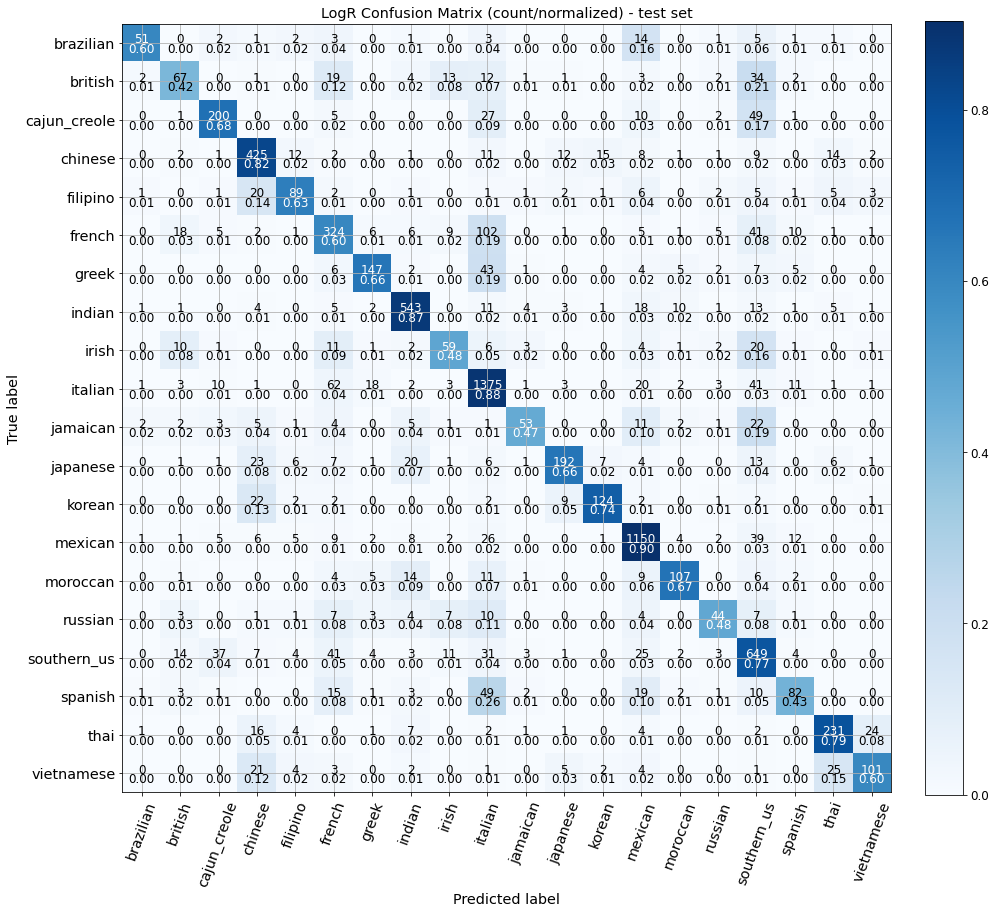

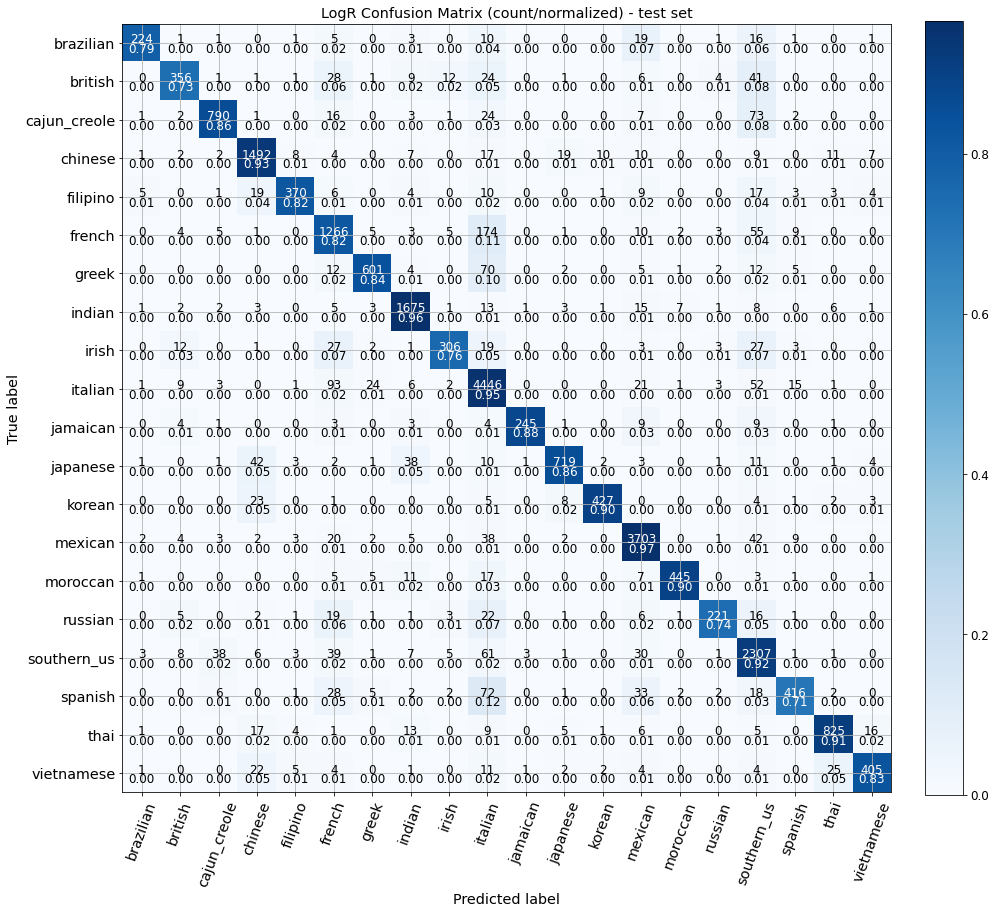

In [34]:
plt.rcParams["font.size"] = "12"
plot_confusion_matrix(cm_lr_test, classes=classes, normalize=True, title="LogR Confusion Matrix (count/normalized) - test set")
plot_confusion_matrix(cm_lr_train, classes=classes, normalize=True, title="LogR Confusion Matrix (count/normalized) - test set")

In [35]:
Counter((y_pred == VLabels).tolist()) # 76.62

Counter({True: 6013, False: 1835})

In [36]:
import pickle
pickle.dump(lr_clf, open('LogRegressionModel.sav', 'wb'))

In [37]:
# model load testing
loadedLogR = pickle.load(open('LogRegressionModel.sav', 'rb'))

In [39]:
Counter((loadedLogR.predict(matrix_test) == VLabels).tolist())

Counter({True: 6013, False: 1835})

In [41]:
vectorizer = TfidfVectorizer(ngram_range=(1, 1))

# Linear SVC model iw tfidf vectorizer
matrix_train = vectorizer.fit_transform(RecipeStrings)
matrix_test = vectorizer.transform(ValRecipeStrings)

# Linear SVC with probability option
lsvc_clf = LinearSVC(random_state=0, tol=1e-5, max_iter=1000)
calibrated_svc = CalibratedClassifierCV(base_estimator=lsvc_clf, ensemble = 'False')
calibrated_svc.fit(matrix_train, Cuisines)

y_pred_svc = calibrated_svc.predict(matrix_test)

print('f1 score weighted %s' % f1_score(VLabels, y_pred_svc, average='weighted'))
print(classification_report(VLabels, y_pred_svc))
cm_lr_test_svc=confusion_matrix(VLabels, y_pred_svc)

print("results of using the LR model on the training data:")
y_pred_train_svc = calibrated_svc.predict(matrix_train)
print('f1 score weighted %s' % f1_score(y_pred_train_svc, Cuisines, average='weighted'))
print(classification_report(Cuisines, y_pred_train_svc))
cm_lr_train_svc = confusion_matrix(Cuisines, y_pred_train_svc)

#What was misclassified in the test and train set?
index = 0
misclassifiedIndexes = []
for label, predict in zip(VLabels, y_pred_svc):
    if label != predict: 
        misclassifiedIndexes.append(index)
    index +=1
print("\n**misclassified in the test set:**\n")
for m in misclassifiedIndexes[:10]:
#     if(y_test[m]=='mexican' and y_pred[m]=='italian'):
    print("{0} classified as {1}:\n{2}\n".format(VLabels[m],y_pred_svc[m],ValRecipeStrings[m]))


index = 0
misclassifiedIndexes = []
for label, predict in zip(Cuisines, y_pred_train_svc):
    if label != predict: 
        misclassifiedIndexes.append(index)
    index +=1
print("\n**misclassified in the train set:**\n")
for m in misclassifiedIndexes[:5]:
    print("{0} classified as {1}:\n{2}\n".format(Cuisines[m],y_pred_train_svc[m],RecipeStrings[m])) 
    

f1 score weighted 0.7760103226925102
              precision    recall  f1-score   support

   brazilian       0.79      0.62      0.70        85
     british       0.54      0.47      0.50       161
cajun_creole       0.76      0.73      0.74       295
     chinese       0.77      0.85      0.81       516
    filipino       0.71      0.63      0.67       141
      french       0.63      0.62      0.62       538
       greek       0.76      0.66      0.71       222
      indian       0.86      0.89      0.87       624
       irish       0.62      0.50      0.55       122
     italian       0.80      0.90      0.84      1558
    jamaican       0.81      0.63      0.71       113
    japanese       0.85      0.69      0.76       290
      korean       0.87      0.73      0.79       167
     mexican       0.88      0.91      0.90      1273
    moroccan       0.82      0.73      0.77       160
     russian       0.65      0.49      0.56        92
 southern_us       0.69      0.77      0.73 

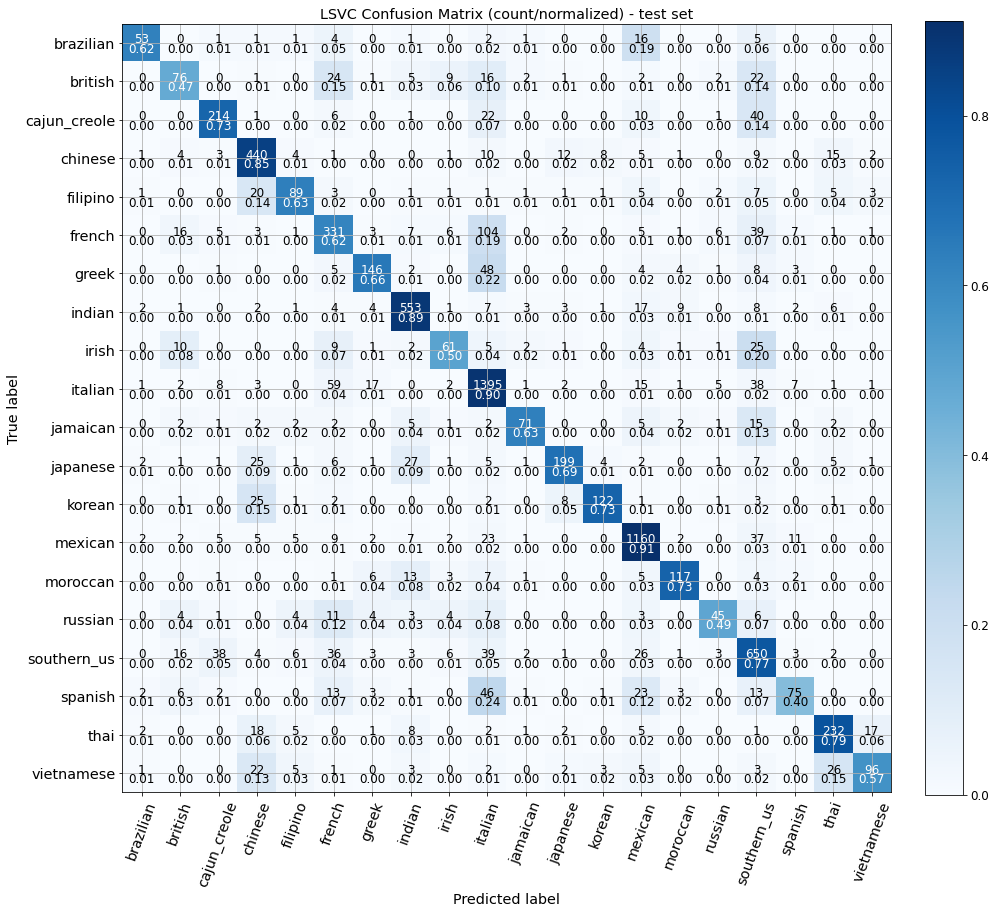

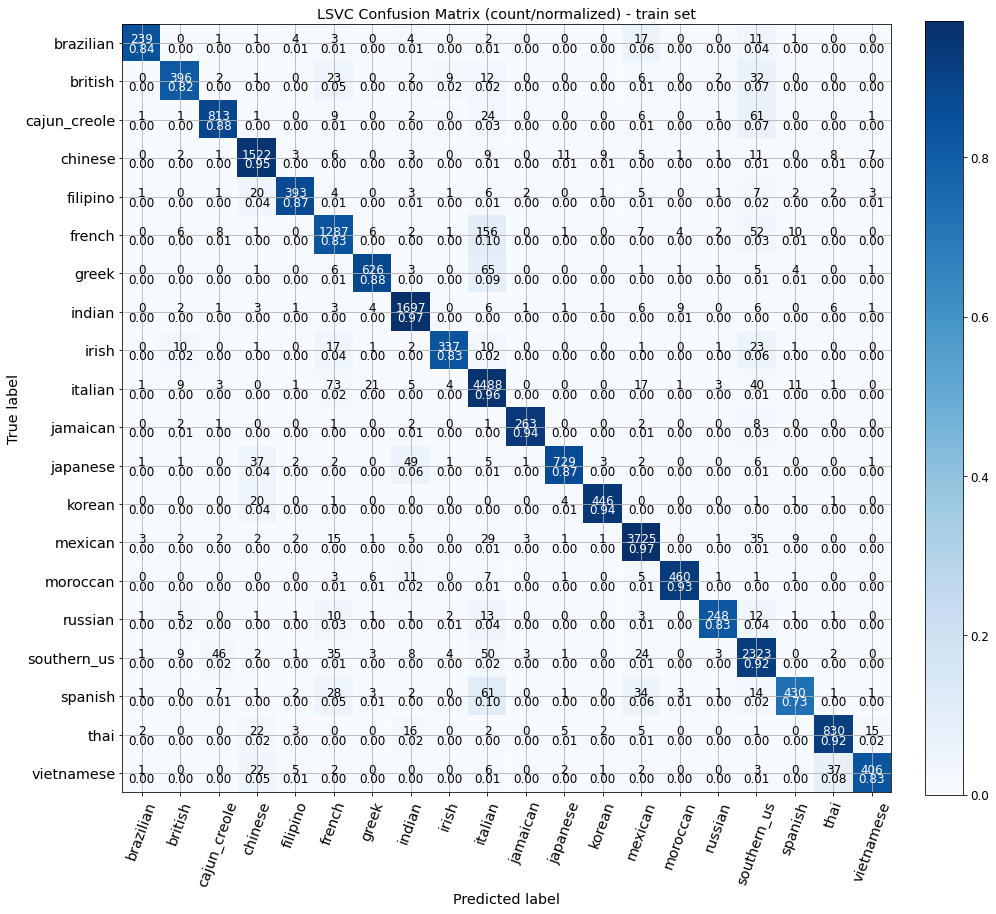

In [42]:
plot_confusion_matrix(cm_lr_test_svc, classes=classes, normalize=True, title="LSVC Confusion Matrix (count/normalized) - test set")
plot_confusion_matrix(cm_lr_train_svc, classes=classes, normalize=True, title="LSVC Confusion Matrix (count/normalized) - train set")

In [43]:
Counter((y_pred_svc == VLabels).tolist()) #78.05

Counter({True: 6125, False: 1723})

In [44]:
# Model saving and testing
pickle.dump(calibrated_svc, open('LinearSVCModel.sav', 'wb'))

In [45]:
LoadedSVC = pickle.load(open('LinearSVCModel.sav', 'rb'))
print(Counter((LoadedSVC.predict(matrix_test) == VLabels).tolist())) # 78.05
LoadedSVC.predict_proba(matrix_test)

Counter({True: 6125, False: 1723})


array([[1.67061860e-03, 1.07398468e-03, 6.92179897e-03, ...,
        3.30038521e-03, 1.74429619e-03, 1.87365144e-03],
       [4.79858473e-04, 2.45102006e-02, 9.00040539e-03, ...,
        1.32511873e-02, 2.43622370e-03, 3.68786743e-03],
       [8.08180419e-03, 8.33984680e-02, 1.54799420e-02, ...,
        5.47518850e-03, 2.73825474e-03, 8.46236342e-03],
       ...,
       [4.68183259e-04, 1.39973662e-04, 1.54971863e-02, ...,
        4.71801069e-03, 2.19483472e-03, 6.70769292e-04],
       [1.23138127e-03, 8.27651005e-03, 2.72363594e-03, ...,
        6.58942163e-04, 1.29701330e-03, 2.03826326e-03],
       [2.10492066e-02, 3.88257667e-04, 7.81156539e-04, ...,
        1.02940030e-02, 6.92999133e-01, 1.74355964e-02]])

# Further Exploration on Best Baseline Model with Focus on Unbalanced Data Strategies (Linear SVC)

## Using inverse weighting of classes

In [47]:
vectorizer = TfidfVectorizer(ngram_range=(1, 1))

# tokenize and build vocab
matrix_train=vectorizer.fit_transform(RecipeStrings)
matrix_test=vectorizer.transform(ValRecipeStrings)

# Linear SVC with probability option 
lsvc_bal = LinearSVC(class_weight='balanced',random_state=0, tol=1e-5, max_iter=1000)
calibrated_svc_bal = CalibratedClassifierCV(base_estimator=lsvc_bal, ensemble = 'False')
calibrated_svc_bal.fit(matrix_train, Cuisines)

lsvc_pred_bal = calibrated_svc_bal.predict(matrix_test)

print('f1 score weighted %s' % f1_score(VLabels,lsvc_pred_bal, average='weighted'))
print(classification_report(VLabels, lsvc_pred_bal))#,target_names=cuisines))
cm_lr_test=confusion_matrix(VLabels, lsvc_pred_bal)
# print(cm_lr_test)

print("results of using the LR model on the training data:")
lsvc_pred_train_bal = calibrated_svc_bal.predict(matrix_train)
print('f1 score weighted %s' % f1_score(lsvc_pred_train_bal, Cuisines, average='weighted'))
print(classification_report(Cuisines, lsvc_pred_train_bal))
cm_lr_train = confusion_matrix(Cuisines, lsvc_pred_train_bal)
# print(cm_lr_train)

#What was misclassified in the test and train set?
index = 0
misclassifiedIndexes = []
for label, predict in zip(VLabels, lsvc_pred_bal):
    if label != predict: 
        misclassifiedIndexes.append(index)
    index +=1
print("\n**misclassified in the test set:**\n")
for m in misclassifiedIndexes[:10]:
#     if(y_test[m]=='mexican' and y_pred[m]=='italian'):
    print("{0} classified as {1}:\n{2}\n".format(VLabels[m],lsvc_pred_bal[m],ValRecipeStrings[m]))


index = 0
misclassifiedIndexes = []
for label, predict in zip(Cuisines, lsvc_pred_train_bal):
    if label != predict: 
        misclassifiedIndexes.append(index)
    index +=1
print("\n**misclassified in the train set:**\n")
for m in misclassifiedIndexes[:5]:
    print("{0} classified as {1}:\n{2}\n".format(Cuisines[m],lsvc_pred_train_bal[m],RecipeStrings[m])) 
    

f1 score weighted 0.772644540205338
              precision    recall  f1-score   support

   brazilian       0.74      0.61      0.67        85
     british       0.52      0.47      0.49       161
cajun_creole       0.74      0.73      0.73       295
     chinese       0.77      0.84      0.80       516
    filipino       0.71      0.62      0.66       141
      french       0.61      0.62      0.62       538
       greek       0.75      0.66      0.70       222
      indian       0.86      0.89      0.87       624
       irish       0.63      0.52      0.57       122
     italian       0.80      0.89      0.84      1558
    jamaican       0.79      0.60      0.68       113
    japanese       0.85      0.69      0.76       290
      korean       0.83      0.72      0.77       167
     mexican       0.89      0.91      0.90      1273
    moroccan       0.81      0.72      0.76       160
     russian       0.62      0.43      0.51        92
 southern_us       0.70      0.78      0.74  

In [48]:
Counter((lsvc_pred_bal == VLabels).tolist()) # 77.69

Counter({True: 6097, False: 1751})

## Using Oversampling and Undersampling Strategies

In [49]:
# Oversampling and Undersampling

from imblearn import pipeline as pl
from imblearn.metrics import classification_report_imbalanced
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

estimator = LinearSVC(random_state=0, tol=1e-5, max_iter=1000)
lr_pipe_os = pl.make_pipeline(TfidfVectorizer(ngram_range=(1, 1)),
                           RandomOverSampler(random_state=123),
                           CalibratedClassifierCV(base_estimator=estimator, ensemble = 'False'))

# Train the classifier with balancing
lr_pipe_os.fit(RecipeStrings, Cuisines)

# Validate the classifier and get the prediction
y_pred_os = lr_pipe_os.predict(ValRecipeStrings)

print("results on oversampling:\n")

# Show the classification report
print(classification_report_imbalanced(VLabels, y_pred_os))
y_pred_train_os = lr_pipe_os.predict(RecipeStrings)
print(classification_report_imbalanced(Cuisines, y_pred_train_os))

cm_lr_os_test = confusion_matrix(VLabels, y_pred_os)
cm_lr_os_train = confusion_matrix(Cuisines, y_pred_train_os)


# Undersampling
lr_pipe_us = pl.make_pipeline(TfidfVectorizer(ngram_range=(1, 1)),
                           RandomUnderSampler(random_state=123),
                           CalibratedClassifierCV(base_estimator=estimator, ensemble = 'False'))

print("results on undersampling:\n")
# Train the classifier with balancing
lr_pipe_us.fit(RecipeStrings, Cuisines)

# Validate the classifier and get the prediction
y_pred_us = lr_pipe_us.predict(ValRecipeStrings)

# Show the classification report
print(classification_report_imbalanced(VLabels, y_pred_us))
y_pred_train_us = lr_pipe_us.predict(RecipeStrings)
print(classification_report_imbalanced(Cuisines, y_pred_train_us))

cm_lr_us_test = confusion_matrix(VLabels, y_pred_us)
cm_lr_us_train = confusion_matrix(Cuisines, y_pred_train_us)

results on oversampling:

                    pre       rec       spe        f1       geo       iba       sup

   brazilian       0.52      0.60      0.99      0.55      0.77      0.57        85
     british       0.36      0.52      0.98      0.43      0.72      0.49       161
cajun_creole       0.67      0.74      0.99      0.70      0.85      0.71       295
     chinese       0.78      0.77      0.99      0.78      0.87      0.74       516
    filipino       0.64      0.71      0.99      0.67      0.84      0.68       141
      french       0.56      0.59      0.97      0.57      0.75      0.54       538
       greek       0.59      0.69      0.99      0.64      0.83      0.66       222
      indian       0.86      0.84      0.99      0.85      0.91      0.82       624
       irish       0.41      0.56      0.99      0.47      0.74      0.53       122
     italian       0.86      0.78      0.97      0.82      0.87      0.74      1558
    jamaican       0.73      0.58      1.00      

In [50]:
print(Counter((y_pred_os == VLabels).tolist()), Counter((y_pred_us == VLabels).tolist())) # 73.53; 67.67

Counter({True: 5771, False: 2077}) Counter({True: 5311, False: 2537})


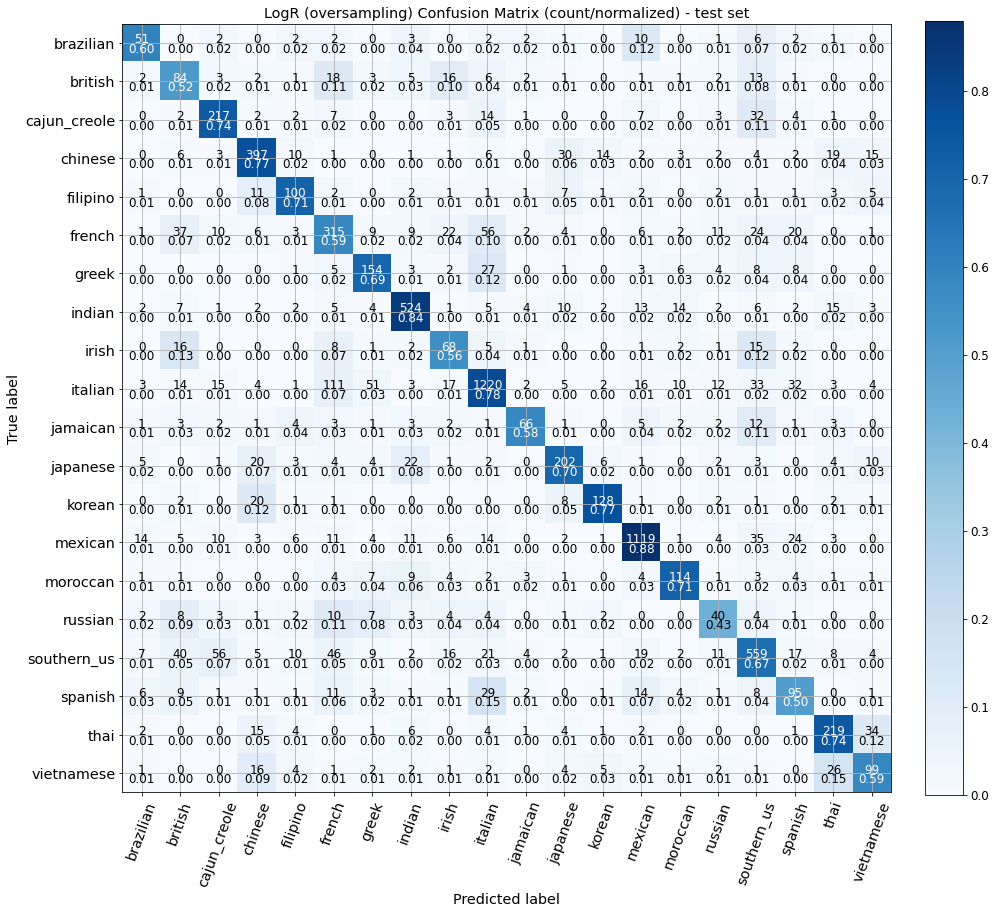

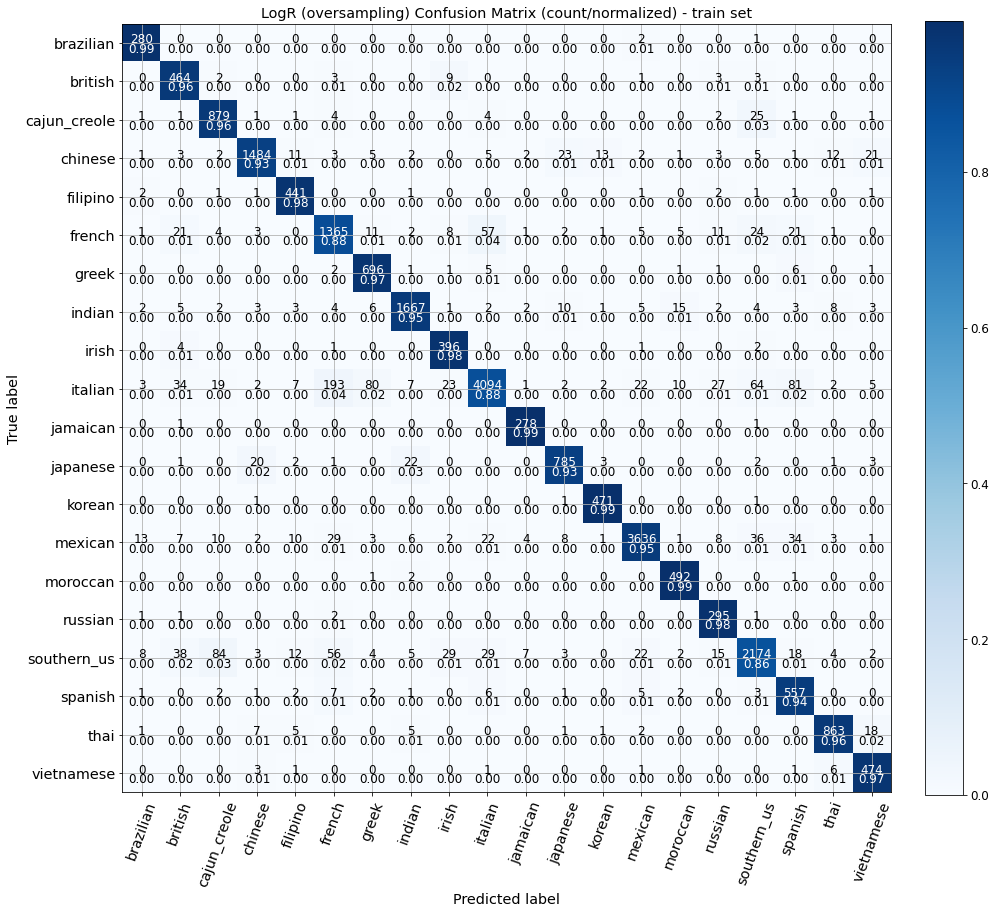

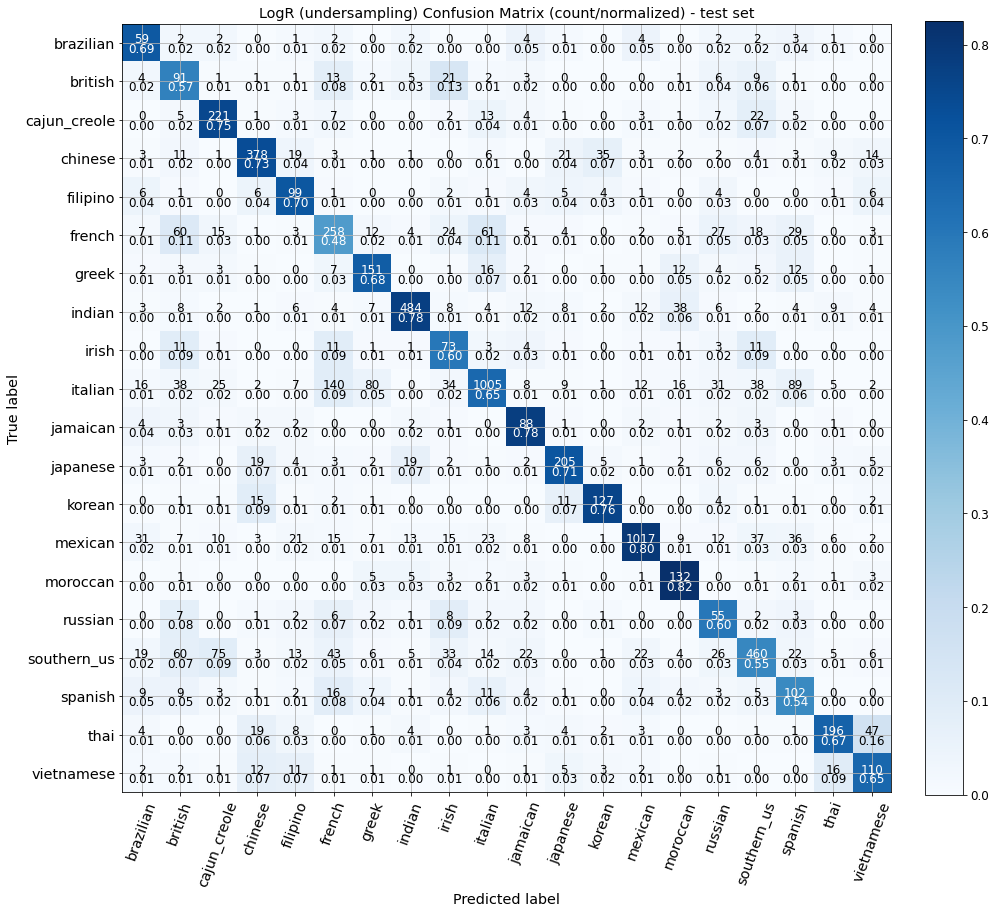

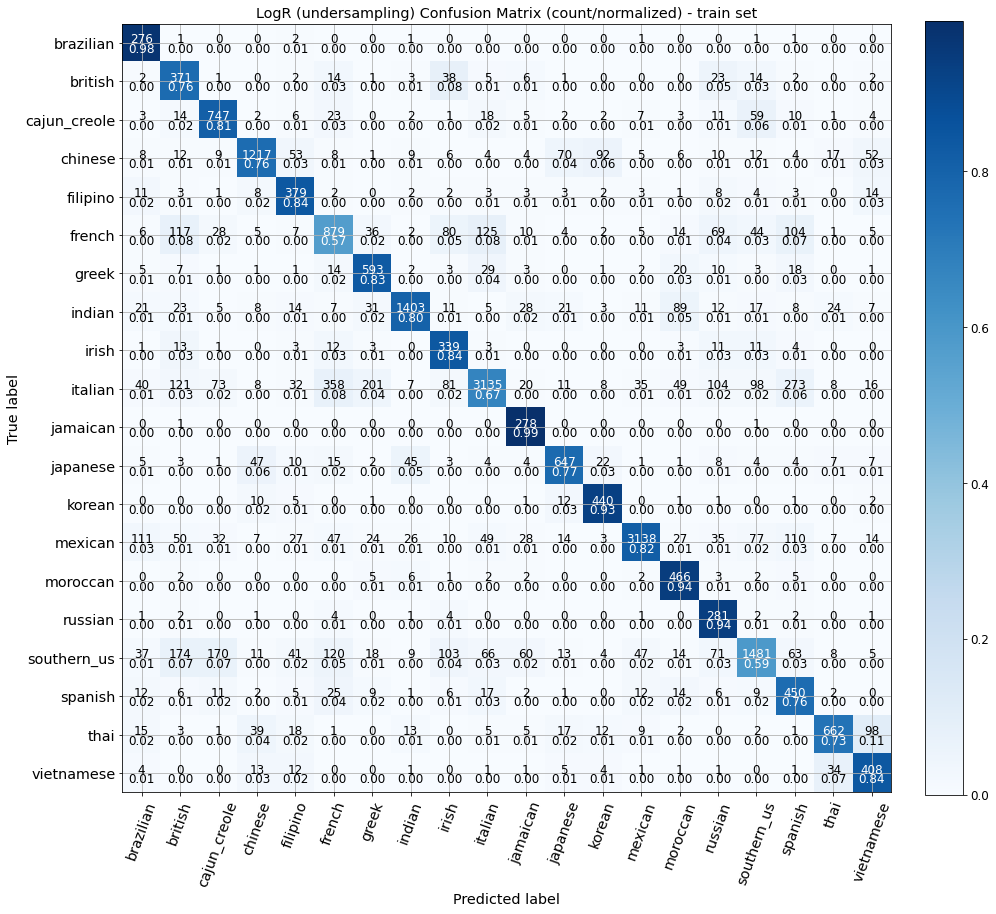

In [51]:
classes=['brazilian', 'british','cajun_creole','chinese','filipino','french', 'greek', 'indian', 'irish', 'italian', 
         'jamaican', 'japanese', 'korean', 'mexican', 'moroccan', 'russian', 'southern_us', 'spanish', 'thai', 'vietnamese']

plot_confusion_matrix(cm_lr_os_test, classes=classes, normalize=True, title="LogR (oversampling) Confusion Matrix (count/normalized) - test set")
plot_confusion_matrix(cm_lr_os_train, classes=classes, normalize=True, title="LogR (oversampling) Confusion Matrix (count/normalized) - train set")

 
plot_confusion_matrix(cm_lr_us_test, classes=classes, normalize=True, title="LogR (undersampling) Confusion Matrix (count/normalized) - test set")
plot_confusion_matrix(cm_lr_us_train, classes=classes, normalize=True, title="LogR (undersampling) Confusion Matrix (count/normalized) - train set")

## Using Chi-square: Selecting Top K significant features

In [52]:
def term_cuisine_count(term):
    '''
    that takes a word, and then counts how many times it occurs 
    for each of the classes
    returns a dictionary
    '''
    term_count_d = {}
    for recipe, cuisine in zip(X_train,y_train):

        if term in recipe:
            if cuisine in term_count_d.keys():
                term_count_d[cuisine] += 1
            else:
                term_count_d[cuisine] = 1
    return term_count_d

In [53]:
# this is another theory to the overfitting and try to deal with it this way
from sklearn.feature_selection import SelectKBest, chi2

vectorizer = TfidfVectorizer(ngram_range=(1, 1))

# tokenize and build vocab
matrix_train = vectorizer.fit_transform(RecipeStrings)
matrix_test = vectorizer.transform(ValRecipeStrings)

chi2score = chi2(matrix_train,Cuisines)[0]
wscores = zip(vectorizer.get_feature_names(),chi2score)
wchi2 = sorted(wscores,key=lambda x:x[1], reverse=True) 

ch2 = SelectKBest(chi2, k=600)
X_chi_train = ch2.fit_transform(matrix_train, Cuisines)
X_chi_test = ch2.transform(matrix_test)

lsvc_chi = LinearSVC(random_state=0, tol=1e-5, max_iter=1000)
calibrated_svc_chi = CalibratedClassifierCV(base_estimator=lsvc_chi, ensemble = 'False')
calibrated_svc_chi.fit(X_chi_train, Cuisines)
y_pred_chi = calibrated_svc_chi.predict(X_chi_test)

print('f1 score weighted %s' % f1_score(VLabels, y_pred_chi, average='weighted'))
print(classification_report(VLabels, y_pred_chi))
cm_chi_test = confusion_matrix(VLabels, y_pred_chi)
print(cm_chi_test)
 
print("results of using the LR model on the training data:")
y_pred_train_chi = calibrated_svc_chi.predict(X_chi_train)
print('f1 score weighted %s' % f1_score(y_pred_train_chi, Cuisines, average='weighted'))
print(classification_report(Cuisines, y_pred_train_chi))
cm_chi_train = confusion_matrix(Cuisines, y_pred_train_chi)
print(cm_chi_train)

print("ingredient words sorted by chi2 with class frequency\n")
index = 1
for term,chi2 in wchi2[:10]:
    print("{0} - {1}: {2}".format(index,term, chi2))
    result_d = term_cuisine_count(term)
    # sort the dictionary results by the count
    sorted_d = sorted(result_d.items(), key=lambda kv: kv[1], reverse=True)
    print(sorted_d)
    print(sorted_d[0][0])
    index += 1

f1 score weighted 0.7227376706081838
              precision    recall  f1-score   support

   brazilian       0.81      0.54      0.65        85
     british       0.47      0.23      0.31       161
cajun_creole       0.77      0.64      0.70       295
     chinese       0.75      0.82      0.79       516
    filipino       0.60      0.52      0.56       141
      french       0.53      0.52      0.52       538
       greek       0.71      0.62      0.66       222
      indian       0.85      0.87      0.86       624
       irish       0.59      0.43      0.50       122
     italian       0.70      0.87      0.78      1558
    jamaican       0.76      0.56      0.64       113
    japanese       0.88      0.63      0.73       290
      korean       0.88      0.67      0.76       167
     mexican       0.85      0.89      0.87      1273
    moroccan       0.78      0.66      0.72       160
     russian       0.64      0.38      0.48        92
 southern_us       0.59      0.68      0.63 

NameError: name 'X_train' is not defined

In [54]:
Counter((y_pred_chi == VLabels).tolist()) # 73.02

Counter({True: 5731, False: 2117})

In [93]:
## Gridsearch
penalty = ['l1', 'l2']

C = [0.001,0.01,0.1,1,1.5,2,5,10,100]

# note even with ngram_range=(1, 1), the chosen hyperparamters are the same
lr_pipe = Pipeline([('vect', TfidfVectorizer(ngram_range=(1, 1))), ('lsvc', LinearSVC(random_state=0, tol=1e-5, max_iter=1000))])

# Create hyperparameter options
hyperparameters = dict(lsvc__C=C, lsvc__penalty=penalty )

#logistic = LogisticRegression(  multi_class='multinomial')
clf = GridSearchCV(lr_pipe, hyperparameters, cv=5, verbose=0)
best_model = clf.fit(RecipeStrings, Cuisines)
print('Best Penalty:', best_model.best_estimator_.get_params()['lsvc__penalty'])
print('Best C:', best_model.best_estimator_.get_params()['lsvc__C'])

c:\users\user\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\user\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\users\user\appdata\local\programs\python\python39\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "c:\users\user\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_classes.py", line 234, in fit
    self.coef_, self.intercept_, self.n_iter_ = _fit_liblinear(
  File "c:\users\user\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py", line 974, in _fit_liblinear
    solver_type = _get_libl

c:\users\user\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\user\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\users\user\appdata\local\programs\python\python39\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "c:\users\user\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_classes.py", line 234, in fit
    self.coef_, self.intercept_, self.n_iter_ = _fit_liblinear(
  File "c:\users\user\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py", line 974, in _fit_liblinear
    solver_type = _get_libl

c:\users\user\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\user\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\users\user\appdata\local\programs\python\python39\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "c:\users\user\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_classes.py", line 234, in fit
    self.coef_, self.intercept_, self.n_iter_ = _fit_liblinear(
  File "c:\users\user\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py", line 974, in _fit_liblinear
    solver_type = _get_libl

c:\users\user\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\user\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\users\user\appdata\local\programs\python\python39\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "c:\users\user\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_classes.py", line 234, in fit
    self.coef_, self.intercept_, self.n_iter_ = _fit_liblinear(
  File "c:\users\user\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py", line 974, in _fit_liblinear
    solver_type = _get_libl

c:\users\user\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\user\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\users\user\appdata\local\programs\python\python39\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "c:\users\user\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_classes.py", line 234, in fit
    self.coef_, self.intercept_, self.n_iter_ = _fit_liblinear(
  File "c:\users\user\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py", line 974, in _fit_liblinear
    solver_type = _get_libl

c:\users\user\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\user\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\users\user\appdata\local\programs\python\python39\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "c:\users\user\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_classes.py", line 234, in fit
    self.coef_, self.intercept_, self.n_iter_ = _fit_liblinear(
  File "c:\users\user\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py", line 974, in _fit_liblinear
    solver_type = _get_libl

c:\users\user\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\user\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\users\user\appdata\local\programs\python\python39\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "c:\users\user\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_classes.py", line 234, in fit
    self.coef_, self.intercept_, self.n_iter_ = _fit_liblinear(
  File "c:\users\user\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py", line 974, in _fit_liblinear
    solver_type = _get_libl

c:\users\user\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
c:\users\user\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
c:\users\user\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [       nan 0.42931145        nan 0.642587          nan 0.75835545
        nan 0.7685904         nan 0.76442845        nan 0.76022414
        nan 0.74153801        nan 0.72735348        nan 0.67842996]
  warnings.warn(


Best Penalty: l2
Best C: 1


# Completion Task

In [55]:
VCAns = pd.read_csv(os.getcwd() + '/project description/validation_completion_answer.csv', engine='python', delimiter=',,', header=None)
VTrain = pd.read_csv(os.getcwd() + '/project description/validation_completion_question.csv', engine= 'python', sep='\,',  names=list(range(58)), dtype='float32')

In [56]:
# completion task training data creation
CompData = []
CompLabel = []
for i, inda in enumerate(TrainRecipeList):
    for a in range(len(inda)):
        compy = inda.copy()
        label = compy.pop(a)
        
        CompData.append(compy)
        CompLabel.append(label)
print(len(CompData), len(CompLabel))

253453 253453


In [57]:
TCompStrings = ToRecipeString(CompData)

In [58]:
VTrain = VTrain.fillna(0)
VCompData = VTrain.values.tolist()
VCompStrings = ToRecipeString(VCompData)

In [59]:
def ConvertLabels(LabelIDs):
    # Conversion of IDs to ingredients
    LReci = [str(int(v)) for v in LabelIDs]
    return LReci

In [60]:
VCAnsL = (np.squeeze(VCAns.values)).tolist() 
VCompLabels = ConvertLabels(VCAnsL)
TCompLabels = ConvertLabels(CompLabel)

In [ ]:
vectorizer = TfidfVectorizer(ngram_range=(1, 1))

# tokenize and build vocab
matrix_train = vectorizer.fit_transform(TCompStrings)
matrix_test = vectorizer.transform(VCompStrings)

# Linear SVC with probability option
lsvc_cc = LinearSVC(random_state=0, tol=1e-5, max_iter=1000)
calibrated_svcc = CalibratedClassifierCV(base_estimator=lsvc_cc, ensemble = 'False')
calibrated_svcc.fit(matrix_train, TCompLabels)

y_pred_svcc = calibrated_svcc.predict(matrix_test)

print('f1 score weighted %s' % f1_score(VLabels, y_pred_svcc, average='weighted'))
print(classification_report(VCompLabels, y_pred_svcc))
cm_lr_test=confusion_matrix(VCompLabels, y_pred_svcc)
# print(cm_lr_test)

print("results of using the LR model on the training data:")
y_pred_train_svcc = calibrated_svcc.predict(matrix_train)
print('f1 score weighted %s' % f1_score(y_pred_train_svcc, TCompLabels, average='weighted'))
print(classification_report(TCompLabels, y_pred_train_svcc))
cm_lr_train = confusion_matrix(TCompLabels, y_pred_train_svcc)
# print(cm_lr_train)

#What was misclassified in the test and train set?
index = 0
misclassifiedIndexes = []
for label, predict in zip(VCompLabels, y_pred_svcc):
    if label != predict: 
        misclassifiedIndexes.append(index)
    index +=1
print("\n**misclassified in the test set:**\n")
for m in misclassifiedIndexes[:10]:
#     if(y_test[m]=='mexican' and y_pred[m]=='italian'):
    print("{0} classified as {1}:\n{2}\n".format(VCompLabels[m],y_pred_svcc[m],VCompStrings[m]))


index = 0
misclassifiedIndexes = []
for label, predict in zip(TCompLabels, y_pred_train_svcc):
    if label != predict: 
        misclassifiedIndexes.append(index)
    index +=1
print("\n**misclassified in the train set:**\n")
for m in misclassifiedIndexes[:5]:
    print("{0} classified as {1}:\n{2}\n".format(TCompLabels[m],y_pred_train_svcc[m],TCompStrings[m])) 
    

c:\users\user\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


In [67]:
print(Counter((y_pred_train_svcc == TCompLabels).tolist()), Counter((y_pred_svcc == VCompLabels).tolist())) # 69.62; 12.81 

Counter({True: 176444, False: 77009}) Counter({False: 6843, True: 1005})
